In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import pandas as pd
import cv2
import glob
import traceback
import xml.etree.ElementTree as ET
import albumentations as A

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.model_selection import train_test_split

import PIL
from PIL import Image 
from PIL.ImageDraw import Draw

2.19.0


In [14]:
def xml_to_csv(path):
    """
    Convert XML files to CSV with multiple classes
    Args:
        path: Path to the folder containing XML files
    Returns:
        Pandas DataFrame with columns ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    """
    xml_list = []
    
    # Get all XML files in the directory
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Get image size
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)
        filename = root.find('filename').text

        # Check for objects
        objects = root.findall('object')
        
        # Function to get class number from name
        def get_class_number(name):
            name = name.strip().lower()
            class_map = {
                'burger': 1,
                'sandwich': 2,
                'hotdog': 3
            }
            return class_map.get(name, 0)  # Returns 0 for 'nothing' or any unknown class
        
        if not objects:
            # No objects found - classify as "nothing" (class 0)
            xml_list.append({
                'filename': filename,
                'width': width,
                'height': height,
                'class': 0,
                'xmin': 0,
                'ymin': 0,
                'xmax': 0,
                'ymax': 0
            })
        else:
            for obj in objects:
                name_tag = obj.find('name')
                if name_tag is not None and name_tag.text is not None:
                    class_num = get_class_number(name_tag.text)
                    bbox = obj.find('bndbox')
                    if bbox is not None:
                        xml_list.append({
                            'filename': filename,
                            'width': width,
                            'height': height,
                            'class': class_num,
                            'xmin': int(bbox.find('xmin').text),
                            'ymin': int(bbox.find('ymin').text),
                            'xmax': int(bbox.find('xmax').text),
                            'ymax': int(bbox.find('ymax').text)
                        })
    
    # Convert to DataFrame
    df = pd.DataFrame(xml_list)
    columns = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    df = df[columns]
    
    # Print statistics
    print("\nClass distribution:")
    print(f"Class 0 (nothing): {len(df[df['class'] == 0])}")
    print(f"Class 1 (burger): {len(df[df['class'] == 1])}")
    print(f"Class 2 (sandwich): {len(df[df['class'] == 2])}")
    print(f"Class 3 (hotdog): {len(df[df['class'] == 3])}")
    print(f"Total annotations: {len(df)}")
    
    return df

In [18]:
df = xml_to_csv('Images')
# Print some statistics
print(f"\nTotal annotations found: {len(df)}")
print(f"Number of burger annotations (class 1): {len(df[df['class'] == 1])}")
print(f"Number of non-burger images (class 0): {len(df[df['class'] == 0])}")

# Save to CSV
output_file = 'Dataset/annotations.csv'
df.to_csv(output_file, index=False)
print(f"\nSaved annotations to {output_file}")
print("\nFirst few rows of the CSV:")
print(df.head())


Class distribution:
Class 0 (nothing): 992
Class 1 (burger): 1485
Class 2 (sandwich): 1782
Class 3 (hotdog): 2480
Total annotations: 6739

Total annotations found: 6739
Number of burger annotations (class 1): 1485
Number of non-burger images (class 0): 992

Saved annotations to Dataset/annotations.csv

First few rows of the CSV:
                                            filename  width  height  class  \
0  1-copy_png.rf.75b0339aa72da0f13d9b38adeea13dbe...    640     360      1   
1    100_png.rf.04808b767e584757447ffa48a789af40.jpg    640     360      1   
2    100_png.rf.11490e40b9e259fabbdb0cedefd2fa65.jpg    640     360      1   
3    100_png.rf.195b003b2b7cfdb4be6e661ca2c1b16a.jpg    640     360      3   
4    100_png.rf.205bbdd58ba30d7abcfe1a67c7c8f91d.jpg    640     360      3   

   xmin  ymin  xmax  ymax  
0   170    43   397   295  
1   224   174   452   361  
2   204    81   379   289  
3   315    43   422   202  
4   232   123   496   219  


In [45]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.85, 1.15),      
        rotate=(-12, 12),      
        translate_percent=(-0.1, 0.1), 
        shear=(-10, 10),          
        p=0.5
    ),
    A.OneOf([
        A.CoarseDropout(num_holes_range=(1, 4), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.35), p=1.0),
        A.GridDropout(ratio=0.3, unit_size_range=(10, 20), fill="inpaint_ns", p=1.0)
    ], p=0.34),
    A.OneOf([
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.15, 0.4), p=1.0),
        A.MotionBlur(
            angle_range=(0, 0),
            direction_range=(0.5, 1.0),
            p=1.0)
    ], p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.85, 1.15),      
        rotate=(-12, 12),      
        translate_percent=(-0.1, 0.1), 
        shear=(-10, 10),          
        p=0.5
    ),
    A.OneOf([
        A.CoarseDropout(num_holes_range=(1, 4), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.35), p=1.0),
        A.GridDropout(ratio=0.3, unit_size_range=(10, 20), fill="inpaint_ns", p=1.0)
    ], p=0.34),
    A.OneOf([
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.15, 0.4), p=1.0),
        A.MotionBlur(
            angle_range=(0, 0),
            direction_range=(0.5, 1.0),
            p=1.0)
    ], p=0.5),
])

empty_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.85, 1.15),      
        rotate=(-12, 12),      
        translate_percent=(-0.1, 0.1), 
        shear=(-10, 10),          
        p=0.5
    ),
    A.OneOf([
        A.CoarseDropout(num_holes_range=(1, 4), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.35), p=1.0),
        A.GridDropout(ratio=0.3, unit_size_range=(10, 20), fill="inpaint_ns", p=1.0)
    ], p=0.34),
    A.OneOf([
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.15, 0.4), p=1.0),
        A.MotionBlur(
            angle_range=(0, 0),
            direction_range=(0.5, 1.0),
            p=1.0)
    ], p=0.5),
])

In [46]:
def augment_image(image_path, annotations_df, output_dir, num_augmentations=5):
    """
    Apply augmentation to both image and bounding boxes
    Args:
        image_path: Path to the image file
        annotations_df: DataFrame containing bounding box annotations
        output_dir: Directory to save augmented images and annotations
        num_augmentations: Number of augmented versions to create
    """
    """
    Apply augmentation to both image and bounding boxes
    Args:
        image_path: Path to the image file
        annotations_df: DataFrame containing bounding box annotations
        output_dir: Directory to save augmented images and annotations
        num_augmentations: Number of augmented versions to create
    """
    
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get base filename without extension
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Get bounding box information for this image
    image_annotations = annotations_df[annotations_df['filename'] == os.path.basename(image_path)]
    if len(image_annotations) == 0:
        print(f"No annotations found for {image_path}")
        return
    
    # Create output directory for annotations if it doesn't exist
    annotations_dir = os.path.join(output_dir, 'annotations')
    if not os.path.exists(annotations_dir):
        os.makedirs(annotations_dir)
    
    new_annotations = []
    
    # Check if this is an image with no objects (class 0)
    is_empty_image = all(row['class'] == 0 for _, row in image_annotations.iterrows())
    
    # Apply augmentation multiple times
    for i in range(num_augmentations):
        if is_empty_image:
            # Apply transforms for empty images
            transformed = empty_transform(image=image)
            augmented_image = transformed['image']
            
            # Create output filenames
            output_filename = f"{base_name}_aug_{i+1}.jpg"
            output_path = os.path.join(output_dir, output_filename)
            
            # Convert RGB back to BGR for saving
            augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
            
            # Save augmented image
            cv2.imwrite(output_path, augmented_image)
            
            # Save annotation with class 0
            new_annotations.append({
                'filename': output_filename,
                'width': 640,
                'height': 360,
                'class': 0,
                'xmin': 0,
                'ymin': 0,
                'xmax': 0,
                'ymax': 0
            })
            
            print(f"Saved augmented empty image: {output_filename}")
            
        else:
            # Prepare bounding boxes and labels for augmentation
            bboxes = []
            class_labels = []
            
            for _, row in image_annotations.iterrows():
                if row['class'] > 0:  # Only include boxes for objects
                    bboxes.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
                    class_labels.append(row['class'])
            
            # Apply the transformation with bounding boxes
            transformed = transform(
                image=image,
                bboxes=bboxes,
                class_labels=class_labels
            )
            
            augmented_image = transformed['image']
            augmented_bboxes = transformed['bboxes']
            
            # Create output filenames
            output_filename = f"{base_name}_aug_{i+1}.jpg"
            output_path = os.path.join(output_dir, output_filename)
            
            # Convert RGB back to BGR for saving
            augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
            
            # Save augmented image
            cv2.imwrite(output_path, augmented_image)
            
            # Save bounding box information
            for bbox, class_label in zip(augmented_bboxes, class_labels):
                new_annotations.append({
                    'filename': output_filename,
                    'width': 640,
                    'height': 360,
                    'class': class_label,
                    'xmin': int(bbox[0]),
                    'ymin': int(bbox[1]),
                    'xmax': int(bbox[2]),
                    'ymax': int(bbox[3])
                })
            
            print(f"Saved augmented image with objects: {output_filename}")
    
    return new_annotations

In [35]:
# Read the annotations CSV
annotations_df = pd.read_csv('Dataset/annotations.csv')

# Create output directory for augmented images
output_dir = "Augmented_Images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get all images from the Images folder
image_paths = glob.glob("Images/*.jpg") + glob.glob("Images/*.png")

# Store all new annotations
all_new_annotations = []

# Apply augmentation to each image
for image_path in image_paths:
    try:
        new_annotations = augment_image(image_path, annotations_df, output_dir)
        if new_annotations:
            all_new_annotations.extend(new_annotations)
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

# Create DataFrame with new annotations and combine with original annotations
new_annotations_df = pd.DataFrame(all_new_annotations)
combined_annotations = pd.concat([annotations_df, new_annotations_df], ignore_index=True)

# Save combined annotations
combined_annotations.to_csv(os.path.join('Dataset', 'annotations_with_augmentation.csv'), index=False)
print("Augmentation completed! Updated annotations saved to 'Dataset/annotations_with_augmentation.csv'")

Saved augmented image and annotations: 1-copy_png.rf.75b0339aa72da0f13d9b38adeea13dbe_aug_1.jpg
Saved augmented image and annotations: 1-copy_png.rf.75b0339aa72da0f13d9b38adeea13dbe_aug_2.jpg
Saved augmented image and annotations: 1-copy_png.rf.75b0339aa72da0f13d9b38adeea13dbe_aug_3.jpg
Error processing Images\100_png.rf.04808b767e584757447ffa48a789af40.jpg: Expected y_max for bbox [0.35       0.48333332 0.70625    1.0027778  1.        ] to be in the range [0.0, 1.0], got 1.0027778148651123.
Saved augmented image and annotations: 100_png.rf.11490e40b9e259fabbdb0cedefd2fa65_aug_1.jpg
Saved augmented image and annotations: 100_png.rf.11490e40b9e259fabbdb0cedefd2fa65_aug_2.jpg
Saved augmented image and annotations: 100_png.rf.11490e40b9e259fabbdb0cedefd2fa65_aug_3.jpg
Saved augmented image and annotations: 100_png.rf.195b003b2b7cfdb4be6e661ca2c1b16a_aug_1.jpg
Saved augmented image and annotations: 100_png.rf.195b003b2b7cfdb4be6e661ca2c1b16a_aug_2.jpg
Saved augmented image and annotations:

In [30]:
def visualize_bbox(img, bbox, class_id, color=(255, 0, 0), thickness=2):
    """Helper function to draw a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    
    # Add class label
    label = f"Class {class_id}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    cv2.putText(img, label, (x_min, y_min-10), font, font_scale, color, thickness)
    
    return img

def visualize_augmented_images(image_path, annotations_df, num_images=4):
    """
    Visualize an original image and its augmented versions with bounding boxes
    
    Args:
        image_path: Path to the original image
        annotations_df: DataFrame containing annotations
        num_images: Number of augmented images to display (including original)
    """
    # Get base filename without extension
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Calculate grid size
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    # Create figure
    plt.figure(figsize=(15, 15))
    
    # Plot original image first
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get original annotations
    orig_annotations = annotations_df[annotations_df['filename'] == os.path.basename(image_path)]
    
    # Draw original bounding boxes
    for _, ann in orig_annotations.iterrows():
        if ann['class'] > 0:  # Skip class 0 (nothing)
            bbox = [ann['xmin'], ann['ymin'], ann['xmax'], ann['ymax']]
            img = visualize_bbox(img.copy(), bbox, ann['class'])
    
    plt.subplot(grid_size, grid_size, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot augmented images
    for i in range(1, num_images):
        aug_filename = f"{base_name}_aug_{i}.jpg"
        aug_path = os.path.join("Augmented_Images", aug_filename)
        
        if os.path.exists(aug_path):
            # Read augmented image
            aug_img = cv2.imread(aug_path)
            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
            
            # Get augmented annotations
            aug_annotations = annotations_df[annotations_df['filename'] == aug_filename]
            
            # Draw augmented bounding boxes
            for _, ann in aug_annotations.iterrows():
                if ann['class'] > 0:  # Skip class 0 (nothing)
                    bbox = [ann['xmin'], ann['ymin'], ann['xmax'], ann['ymax']]
                    aug_img = visualize_bbox(aug_img.copy(), bbox, ann['class'])
            
            plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(aug_img)
            plt.title(f'Augmented {i}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

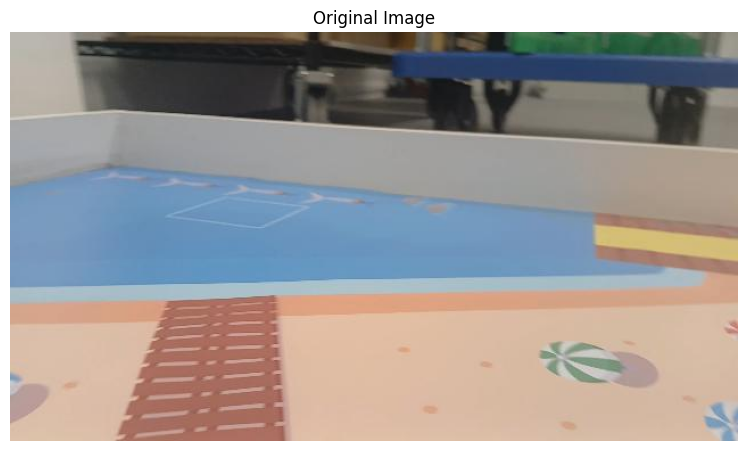

In [44]:
# Read the combined annotations
annotations_df = pd.read_csv('Dataset/annotations_with_augmentation.csv')

# 1. Visualize specific image and its augmentations
original_image_path = "Images/9_png.rf.e49409fd96a8a79a952041fbbb5fa536.jpg"  # Replace with actual image path
visualize_augmented_images(original_image_path, annotations_df)

In [42]:
def split_dataset(csv_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=202):
    """
    Split the dataset into train, validation and test sets while maintaining class balance
    
    Args:
        csv_path: Path to the annotations CSV file
        train_ratio: Ratio of training data (default: 0.7)
        val_ratio: Ratio of validation data (default: 0.15)
        test_ratio: Ratio of test data (default: 0.15)
        random_state: Random seed for reproducibility
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Create separate dataframes for each class
    nothing_samples = df[df['class'] == 0]
    burger_samples = df[df['class'] == 1]
    sandwich_samples = df[df['class'] == 2]
    hotdog_samples = df[df['class'] == 3]
    
    print(f"Total samples: {len(df)}")
    print(f"Nothing samples (class 0): {len(nothing_samples)}")
    print(f"Burger samples (class 1): {len(burger_samples)}")
    print(f"Sandwich samples (class 2): {len(sandwich_samples)}")
    print(f"Hotdog samples (class 3): {len(hotdog_samples)}")
    
    # First split: separate test set for each class
    nothing_train_val, nothing_test = train_test_split(
        nothing_samples, 
        test_size=test_ratio, 
        random_state=random_state
    )
    
    burger_train_val, burger_test = train_test_split(
        burger_samples, 
        test_size=test_ratio, 
        random_state=random_state
    )
    
    sandwich_train_val, sandwich_test = train_test_split(
        sandwich_samples, 
        test_size=test_ratio, 
        random_state=random_state
    )
    
    hotdog_train_val, hotdog_test = train_test_split(
        hotdog_samples, 
        test_size=test_ratio, 
        random_state=random_state
    )
    
    # Second split: separate train and validation from the remaining data
    val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
    
    nothing_train, nothing_val = train_test_split(
        nothing_train_val, 
        test_size=val_ratio_adjusted, 
        random_state=random_state
    )
    
    burger_train, burger_val = train_test_split(
        burger_train_val, 
        test_size=val_ratio_adjusted, 
        random_state=random_state
    )
    
    sandwich_train, sandwich_val = train_test_split(
        sandwich_train_val, 
        test_size=val_ratio_adjusted, 
        random_state=random_state
    )
    
    hotdog_train, hotdog_val = train_test_split(
        hotdog_train_val, 
        test_size=val_ratio_adjusted, 
        random_state=random_state
    )
    
    # Combine samples for each set
    train_df = pd.concat([nothing_train, burger_train, sandwich_train, hotdog_train])
    val_df = pd.concat([nothing_val, burger_val, sandwich_val, hotdog_val])
    test_df = pd.concat([nothing_test, burger_test, sandwich_test, hotdog_test])
    
    # Shuffle each dataset
    train_df = train_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    val_df = val_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Print statistics
    print("\nDataset split statistics:")
    print(f"Training set: {len(train_df)} samples")
    print(f"  - Nothing (class 0): {len(train_df[train_df['class'] == 0])}")
    print(f"  - Burger (class 1): {len(train_df[train_df['class'] == 1])}")
    print(f"  - Sandwich (class 2): {len(train_df[train_df['class'] == 2])}")
    print(f"  - Hotdog (class 3): {len(train_df[train_df['class'] == 3])}")
    
    print(f"\nValidation set: {len(val_df)} samples")
    print(f"  - Nothing (class 0): {len(val_df[val_df['class'] == 0])}")
    print(f"  - Burger (class 1): {len(val_df[val_df['class'] == 1])}")
    print(f"  - Sandwich (class 2): {len(val_df[val_df['class'] == 2])}")
    print(f"  - Hotdog (class 3): {len(val_df[val_df['class'] == 3])}")
    
    print(f"\nTest set: {len(test_df)} samples")
    print(f"  - Nothing (class 0): {len(test_df[test_df['class'] == 0])}")
    print(f"  - Burger (class 1): {len(test_df[test_df['class'] == 1])}")
    print(f"  - Sandwich (class 2): {len(test_df[test_df['class'] == 2])}")
    print(f"  - Hotdog (class 3): {len(test_df[test_df['class'] == 3])}")
    
    # Save the splits to CSV files
    train_df.to_csv('Dataset/train.csv', index=False)
    val_df.to_csv('Dataset/val.csv', index=False)
    test_df.to_csv('Dataset/test.csv', index=False)
    
    return train_df, val_df, test_df

In [43]:
train_df, val_df, test_df = split_dataset('Dataset/annotations_with_augmentation.csv')

Total samples: 23893
Nothing samples (class 0): 992
Burger samples (class 1): 5883
Sandwich samples (class 2): 7110
Hotdog samples (class 3): 9908

Dataset split statistics:
Training set: 16721 samples
  - Nothing (class 0): 694
  - Burger (class 1): 4117
  - Sandwich (class 2): 4976
  - Hotdog (class 3): 6934

Validation set: 3586 samples
  - Nothing (class 0): 149
  - Burger (class 1): 883
  - Sandwich (class 2): 1067
  - Hotdog (class 3): 1487

Test set: 3586 samples
  - Nothing (class 0): 149
  - Burger (class 1): 883
  - Sandwich (class 2): 1067
  - Hotdog (class 3): 1487


In [ ]:
TRAIN_CSV_FILE = 'Dataset/train.csv'
VAL_CSV_FILE = 'Dataset/val.csv'
TEST_CSV_FILE = 'Dataset/test.csv'
IMAGE_DIR = 'Images'

def prepare_dataset(csv_file, image_dir):
    """
    Prepare images, targets and labels from a CSV file
    
    Args:
        csv_file: Path to CSV file containing annotations
        image_dir: Directory containing the images
        
    Returns:
        images: numpy array of images
        targets: dictionary containing class and bbox outputs
        labels: numpy array of class labels
    """
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    images = []
    bbox_targets = []
    class_labels = []
    
    for index, row in df.iterrows():
        # Extract data from row
        filename = row['filename']
        width = row['width']
        height = row['height']
        class_label = row['class']  # Assuming this is 0 or 1 for binary classification
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']
        
        # Load and preprocess image
        image_path = os.path.join(image_dir, filename)
        img = keras.preprocessing.image.load_img(image_path, target_size=(360, 640))  # Fixed size for all images
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize pixel values
        
        # Normalize bounding box coordinates
        bbox = [
            round(xmin/width, 4),
            round(ymin/height, 4),
            round(xmax/width, 4),
            round(ymax/height, 4)
        ]
        
        images.append(img_array)
        bbox_targets.append(bbox)
        class_labels.append(class_label)
    
    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    bbox_targets = np.array(bbox_targets, dtype=np.float32)
    class_labels = np.array(class_labels, dtype=np.float32)
    
    # Create targets dictionary for multi-output model
    targets = {
        'class_output': class_labels,
        'bbox_output': bbox_targets
    }
    
    return images, targets

# Prepare train, validation and test sets
print("Preparing training data...")
train_images, train_targets = prepare_dataset(TRAIN_CSV_FILE, IMAGE_DIR)

print("Preparing validation data...")
val_images, val_targets = prepare_dataset(VAL_CSV_FILE, IMAGE_DIR)

print("Preparing test data...")
test_images, test_targets = prepare_dataset(TEST_CSV_FILE, IMAGE_DIR)

# Print shapes to verify
print("\nDataset shapes:")
print(f"Training images: {train_images.shape}")
print(f"Training class labels: {train_targets['class_output'].shape}")
print(f"Training bbox targets: {train_targets['bbox_output'].shape}")
print(f"\nValidation images: {val_images.shape}")
print(f"Validation class labels: {val_targets['class_output'].shape}")
print(f"Validation bbox targets: {val_targets['bbox_output'].shape}")
print(f"\nTest images: {test_images.shape}")
print(f"Test class labels: {test_targets['class_output'].shape}")
print(f"Test bbox targets: {test_targets['bbox_output'].shape}")

In [11]:
def create_model():
    base_model = MobileNetV3Large(
        input_shape=(360,640,3),
        include_top=False, 
        weights='imagenet'
    )
    base_model.trainable = True

    x = base_model.output

    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    ########## block 1 ##########
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x_shortcut = x

    for i in range(2):
        x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x_shortcut = x


    ########## block 2 ##########
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x_shortcut = x

    for i in range(2):
        x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x_shortcut = x

    ########## block 3 ##########
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x_shortcut = x

    for i in range(3):
        x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x_shortcut = x

        
    ########## block 4 ##########
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x_shortcut = x

    for i in range(5):
        x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x_shortcut = x

    ########## block 5 ##########
    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x_shortcut = x

    for i in range(8):
        x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x_shortcut = x

    ########## output layers ##########
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # Classification head
    class_branch = tf.keras.layers.GlobalAveragePooling2D()(x)
    class_branch = tf.keras.layers.Dense(64, activation='relu')(class_branch)
    class_output = tf.keras.layers.Dense(4, activation='sigmoid', name='class_output')(class_branch)

    # Bounding box head
    bbox_branch = tf.keras.layers.GlobalAveragePooling2D()(x)
    bbox_branch = tf.keras.layers.Dense(64, activation='relu')(bbox_branch)
    bbox_output = tf.keras.layers.Dense(4, activation='sigmoid', name='bbox_output')(bbox_branch)

    model = tf.keras.Model(
        inputs=base_model.input, 
        outputs={
            'class_output': class_output,
            'bbox_output': bbox_output
        }
    )
    return model

model = create_model()

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        'class_output': 'binary_crossentropy',
        'bbox_output': 'mse'
    },
    metrics={
        'class_output': 'accuracy',
        'bbox_output': 'mse'
    }
)

model.summary()

In [ ]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            restore_best_weights=True
        )
    ]

history = model.fit(
        train_images,
        train_targets,
        validation_data=(val_images, val_targets),
        epochs=64,
        batch_size=32,
        callbacks=callbacks
    )

model.save('my_model.keras')

In [ ]:
test_img = 'Images/448_png.rf.c0d24997b23fb6a4844cc647456b99d0.jpg'
model = create_model()
model.load_weights('best_model.h5')

img = keras.preprocessing.image.load_img(test_img, target_size=(360, 640))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
print(predictions)

In [ ]:
bbox = predictions["bbox_output"]
bbox = [bbox[0][0] * 640, bbox[0][1] * 360, bbox[0][2] * 640, bbox[0][3] * 360]
print(bbox)

score = predictions["class_output"]
score = tf.nn.softmax(score)
print(score)
# class_prediction_value = round(predictions["class_output"][0][0])

# classes = ["nothing", "burger"]
# print("Predicted class: {}".format(classes[class_prediction_value]))

In [13]:
testing = keras.preprocessing.image.load_img(test_img, target_size=(360, 640))

img_width, img_height = testing.size
x1 = int(bbox[0])
y1 = int(bbox[1])
x2 = int(bbox[2])
y2 = int(bbox[3])

draw1 = Draw(testing)
bbox_pixels = [(x1, y1), (x2, y2)]
draw1.rectangle(bbox_pixels, outline='red', width=3)
testing.show()

In [ ]:
cam = cv2.VideoCapture(1) 
cam.set(cv2.CAP_PROP_FPS, 120)

while True:
    ret, frame = cam.read()

    frame_resized = cv2.resize(frame, (640, 360))
    frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)

    img_array = tf.expand_dims(frame_rgb, 0)

    predictions = model.predict(img_array, verbose=0)

    bbox = predictions["bbox_output"]
    bbox = [bbox[0][0] * 640, bbox[0][1] * 360, bbox[0][2] * 640, bbox[0][3] * 360]

    class_prediction_value = round(predictions["class_output"][0][0])
    class_name = classes[class_prediction_value]
    print(class_name)

    if class_name != "nothing":
        x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        cv2.rectangle(frame_resized, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame_resized, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    cv2.imshow('Camera Feed', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.release()
cv2.destroyAllWindows()